#**Evaluation**


*   load custom images and classify wearing a mask or not
*   show the test images and prediction or/and scores

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from google.colab.patches import cv2_imshow
import os
import cv2
import numpy as np
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [8]:
# 1. prepare data
test_transforms =  transforms.Compose([
    transforms.ToTensor(),        
    transforms.Normalize((0.3,), (1.0,)),
    transforms.Resize(112),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomPerspective(),
    # transforms.ColorJitter(brightness=0.5),
    # transforms.RandomRotation(20),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 3))
          ])

test_path = '/content/drive/MyDrive/인공지능개론 프로젝트/test'

test_data = datasets.ImageFolder(test_path, test_transforms)
# check the label
test_data.class_to_idx

{'not_wearing_mask': 0, 'wearing_mask': 1}

In [9]:
# 2. load model

save_path = "/content/drive/MyDrive/인공지능개론 프로젝트/Result/20230608-131816/"

model = torchvision.models.resnet50(pretrained=True, progress=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model = model.to(device)
model.load_state_dict(torch.load(save_path+'resnet50_lambdalr_pretrained true.pth'))

# optimizer, loss, scheduler
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

# data_loader
batch_size = 64

test_loader = DataLoader(dataset=test_data, 
                         batch_size=batch_size,
                         shuffle=True)

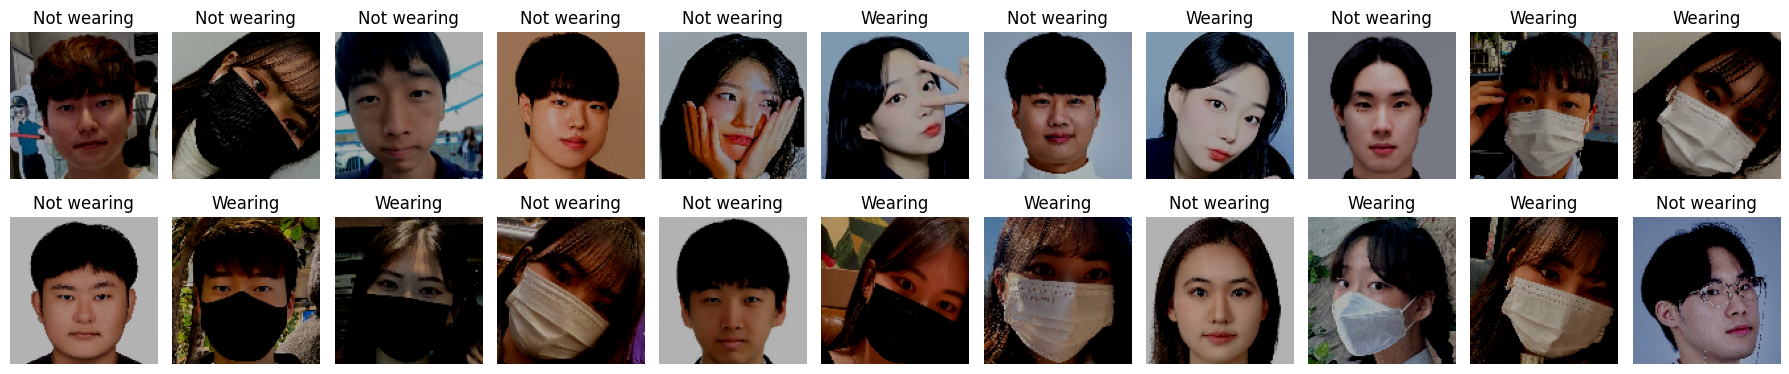

evaluation loss: 0.61138, evaluation accuracy: 0.81818


In [10]:
# 3. perform evaluation
model.eval()
running_loss = 0
acc_temp = 0
total_images = 0

with torch.no_grad():

    fig, axes = plt.subplots(2, 11, figsize=(18, 4))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Adjust spacing between subplots


    for img, lbl in test_loader:
        img, lbl = img.to(device), lbl.to(device)
        lbl = lbl.unsqueeze(1)
        batch_size = img.size(0)
        output = model(img)
        pred = output
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        acc_temp += (pred == lbl).sum().item()
        running_loss += loss_fn(output.float(), lbl.float()).item() * batch_size

        for i in range(batch_size):
          img_out = img[i].permute(1, 2, 0).cpu().numpy()  # Convert image to RGB format
          test_pred = pred[i].cpu().int()
          test = lbl[i].cpu()

          row = total_images // 11
          col = total_images % 11
          axes[row, col].imshow(img_out)
          if(test_pred.item()==0):
            axes[row, col].set_title("Not wearing")
          elif(test_pred.item()==1):
            axes[row, col].set_title("Wearing")
          axes[row, col].axis('off')

          total_images += 1

        if total_images >= 22:  # Break if all images have been displayed
          break

    plt.tight_layout()
    plt.show() 

test_loss = running_loss / total_images
test_acc = acc_temp / total_images

# Print loss, accuracy and plot an example
print(f'evaluation loss: {test_loss:.5f}, evaluation accuracy: {test_acc:.5f}')